# Machine Learning for Finance -  Homework 2

Simone Robba

# Overview

In this work, the dataser regarding the credit provision is used again. 
The goal is not only implement a set of different models to predict the default of a potential borrower, but to select the best Hyperparameter among a set provided.

Three models are tested: 
- Logistic Regression (LR)
- Support Vector Machine (SVM), 
- Ada Boost with Decision Tree (TREE) as base classifier

Each classifier is incorporated in a pipeline that first standardize the features, then extract them in a set of Principal Components (PC). 
The pipeline then undertake a Grid Search analysis to evaluate the best hyperparametes. For each model, one or two hyperparameters are set as variable, and a set of values is evaluated for each of them.
The performance of each model is estimated through accuracy score with a K-fold cross-validation technique.
Finally, the performance of the models, with the relative selected hyperparameters, is calculated on the test dataset.

Logistic Regression
Hyperparameters evaluated:
- Penalty (l1, l2)
- C: (0.001, 1, 10, 100.0)
- Test accuracy: Test accuracy: 0.985 (C: 0.001 Penalty: l1)

Support Vector Machine
Hyperparameters evaluated:
- Kernel: linear
- C: (0.001, 100)
- Test accuracy: 0.985 (C: 0.001)

Ada Boost
- estim_range:(10, 100, 500)
- max_depth: (1, 2, 3)
- Test accuracy: 0.985 (estimators: 10 max_depth: 1)
   

# Disclaimer

An analysis of the variance of the original training dataset revealed that the optimal number of PC to mantain during the PCA transformation were 6/7, in order to keep information regarding the 75/80% of the variance of the feature matrix.

In the following code the first three models (LR, SVC, Tree) are inserted in a pipeline that standardize and extract the features, then run the classifier. Subsequently, the next tree models also undertake a grid search and a 5-fold cross evaluation. This makes the calculation of the results much more computationally heavy, and it resulted impossible to finalize it on my computer (I let the code run overnight and after 8 hours the result was not ready yet).

Therefore I made a modification on the original dataset, mantaining only the first 5,000 observations in both the training and test dataset. Also, because of the same constraints, I extracted the features in 3 PC only.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
import matplotlib
from distutils.version import LooseVersion
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier

In the following code the train feature matrix, train y matrix, test feature matrix and test y matrix are extracted from the related csv files. Both the train and test feature matrix contain NaN values, which are substituted with the mean value of the whole feature vector. After that, the feature matrix are standardized.

The relevant numpy array produced are the following:

- X_train_std: Feature matrix of the train dataset, standardized.
- X_test_std: Feature matrix of the test dataset, standardized.
- y_train: Output matrix of the train dataset
- y_test_int: Output matrix of the test dataset, transformed in integers 0/1 on the base of the related probability values.

While the standardized matrices will be used for an initial discussion regarding the PCA freature extraction, the pipelines that will be implemented later will take care of the standardization without the need to imput standardized matrices. In that case, the feature matrices used will be:
- X_train
- X_test

In [8]:
df = pd.read_csv('Small Dataset - cs-training.csv', header= 0, index_col=0, encoding='utf-8')
Xy0_test = pd.read_csv('Small Dataset - cs-test.csv', header= 0, index_col=0, encoding='utf-8')
y0_test = pd.read_csv('Small Dataset - sampleEntry.csv', header= 0, index_col=0, encoding='utf-8')
y_test = y0_test.iloc[:, 0].values    #y_test
y_test_int = np.round(y_test)         
y_test_int = y_test_int.astype(int) #y_test_int
df2= df.fillna(df.mean())
Xy_test = Xy0_test.fillna(df.mean())
X_train, y_train = df2.iloc[:, 1:].values, df2.iloc[:, 0].values     #X_train   y_train
X_test=Xy_test.iloc[:, 1:].values     #X_test
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)   #X_train_std
X_test_std = sc.transform(X_test)         #X_test_std

In [9]:
print("Small Dataset - cs-training.csv shape:", df.shape)
print("Small Dataset - cs-test.csv shape:", Xy0_test.shape)
print("Small Dataset - sampleEntry.csv shape:", y0_test.shape)

Small Dataset - cs-training.csv shape: (5000, 11)
Small Dataset - cs-test.csv shape: (5000, 11)
Small Dataset - sampleEntry.csv shape: (5000, 1)


# PCA: Selecting the number of components

The standardized train feature matrix is used to implement a Principal Component Analysis, without contrains regarding the number of components, that compute the variance explained by each component.

Subsequently, a chart is plotted to show the cumulative variance explined by the components, sorted from the most significant.

In [10]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
eigen_vals = pca.explained_variance_ratio_
eigen_vals

array([0.29710567, 0.16293871, 0.11992219, 0.10133304, 0.0998272 ,
       0.08625448, 0.0747893 , 0.05339751, 0.00339065, 0.00104124])

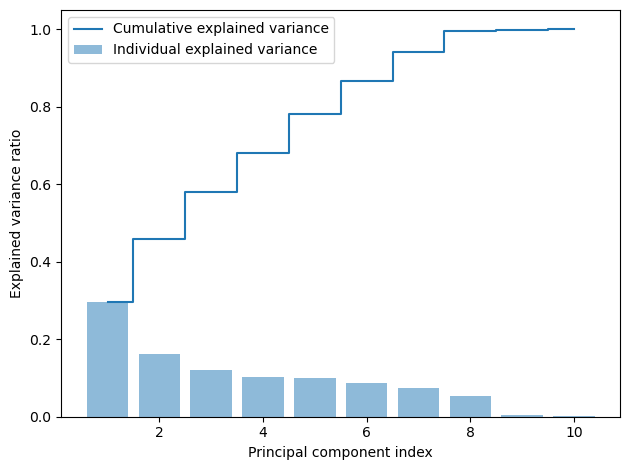

In [11]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 11), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 11), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

In [12]:
print("Cumulative variance explained:", cum_var_exp)

Cumulative variance explained: [0.29710567 0.46004438 0.57996657 0.68129961 0.78112682 0.86738129
 0.9421706  0.99556811 0.99895876 1.        ]


According with the results, it would be reasonable to select the first 5/6 PC, in order to mantain information capable of explaining about 75/85% of the variance in the feature matrix. 
Hovewer, due to computational constraints, I'll just select the first 3.

# Models with default hyperparameters

A test is run to track the performance on the test dataset of LR, SVM, and ADA, with default hyperparameters.

In [13]:
pipe_svc_test = make_pipeline(StandardScaler(),
                         PCA(n_components=3),
                         SVC(random_state=1, kernel = 'linear'))

pipe_svc_test.fit(X_train, y_train)
pipe_svc_test_score = pipe_svc_test.score(X_test, y_test_int)
print("Support Vector Machine")
print('Test Accuracy: %.3f' % pipe_svc_test_score)

Default_Hyperparametes = []
Default_Hyperparametes.append(pipe_svc_test_score)

Support Vector Machine
Test Accuracy: 0.985


In [14]:
pipe_lr_test = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1, solver='liblinear'))

pipe_lr_test.fit(X_train, y_train)
pipe_lr_test_score = pipe_lr_test.score(X_test, y_test_int)
print("Logistic Regression")
print('Test Accuracy: %.3f' % pipe_lr_test_score)

Default_Hyperparametes.append(pipe_lr_test_score)

Logistic Regression
Test Accuracy: 0.983


In [15]:
tree = DecisionTreeClassifier(random_state=1)

pipe_ada_test = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        AdaBoostClassifier(estimator=tree, 
                         learning_rate=0.1,
                         random_state=1))

pipe_ada_test.fit(X_train, y_train)
pipe_ada_test_score = pipe_ada_test.score(X_test, y_test_int)
print("Ada Boost")
print('Test Accuracy: %.3f' % pipe_ada_test_score)

Default_Hyperparametes.append(pipe_ada_test_score)

Ada Boost
Test Accuracy: 0.936


# SVM - Hyperparameter Tuning

With the following code a pipeline is created that standardize the features, and extract them in 3 PC. 

A Grid search analysis is run, which, thrugh a 5 Fold Cross validation, select the best value for C among the set (0.001, 100.0)

Best value C:0.001

Mean score on the Validation sets: 0.9389999999999998

In [16]:
pipe_svc = make_pipeline(StandardScaler(),
                         PCA(n_components=3),
                         SVC(random_state=1))

param_range = [0.001, 100.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']}]

gs_svc = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs_svc = gs_svc.fit(X_train, y_train)
print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.9389999999999998
{'svc__C': 0.001, 'svc__kernel': 'linear'}


A chart il splotted to show the change in performance when changing the C value, fixing the kernel as "linear".

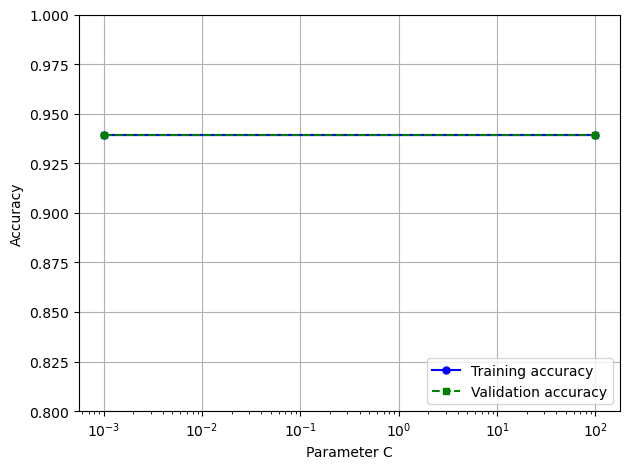

In [17]:
pipe_svc = make_pipeline(StandardScaler(),
                         PCA(n_components=3),
                         SVC(random_state=1, kernel="linear"))

param_range_svc = [0.001, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_svc, 
                X=X_train, 
                y=y_train, 
                param_name='svc__C', 
                param_range=param_range_svc,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range_svc, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range_svc, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range_svc, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range_svc, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [18]:
print("Validation set means")
print("C=", param_range_svc[0], "   Accuracy:", test_mean[0])
print("C=", param_range_svc[1], "   Accuracy:", test_mean[1])

Validation set means
C= 0.001    Accuracy: 0.9389999999999998
C= 100.0    Accuracy: 0.9389999999999998


The SVC Model, with 
- C: 0.001 
- Kernel: linear 

has an Accuracy Score on the Test dataset of 0.985

In [19]:
clf_svc = gs_svc.best_estimator_
clf_svc_score = clf_svc.score(X_test, y_test_int)

print("Best hyperparameters:", gs_svc.best_params_)
print('Test accuracy: %.3f' % clf_svc_score)

Selected_Hyperparametes = []
Selected_Hyperparametes.append(clf_svc_score)

Best hyperparameters: {'svc__C': 0.001, 'svc__kernel': 'linear'}
Test accuracy: 0.985


# Logistic Regression

For the Logistic Regression, the pipeline newly standardize the features, and extract them in 3 PC. 

A Grid search analysis is run, which, thrugh a 5 Fold Cross validation, select the best value for C among the set (0.001, 1, 10, 100.0) and the best penalty type between l1 and l2

Best penalty: l1

Best value for C: 0.001

Mean score on the Validation sets: 0.9389999999999998

In [20]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1, solver='liblinear'))

param_range_lr = [0.001, 1, 10, 100.0]

param_grid_lr = [{'logisticregression__C': param_range_lr, 
               'logisticregression__penalty': ['l1', "l2"]}]

gs_lr = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid_lr, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs_lr = gs_lr.fit(X_train, y_train)

print(gs_lr.best_score_)
print(gs_lr.best_params_)

0.9389999999999998
{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l1'}


A chart il splotted to show the change in performance when changing the C value, fixing the penalty as "l1".

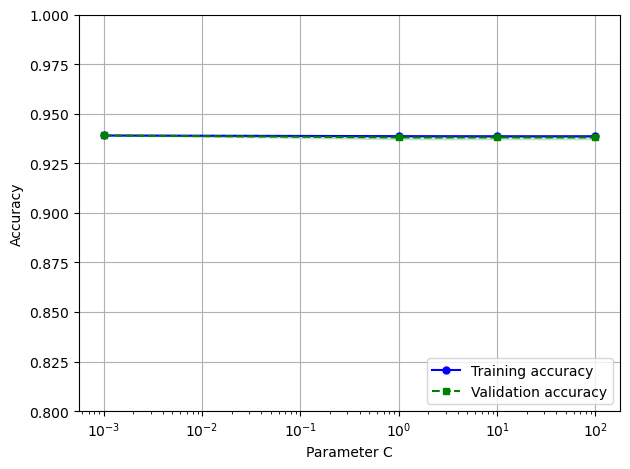

In [21]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(penalty = "l1", random_state=1, solver='liblinear'))

param_range_lr = [0.001, 1, 10, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range_lr,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range_lr, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range_lr, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range_lr, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range_lr, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [22]:
print("Validation set means")
print("C=", param_range_lr[0], "   Accuracy:", test_mean[0])
print("C=", param_range_lr[1], "       Accuracy:", test_mean[1])
print("C=", param_range_lr[2], "      Accuracy:", test_mean[2])
print("C=", param_range_lr[3], "   Accuracy:", test_mean[3])

Validation set means
C= 0.001    Accuracy: 0.9389999999999998
C= 1        Accuracy: 0.9380000000000001
C= 10       Accuracy: 0.9380000000000001
C= 100.0    Accuracy: 0.9380000000000001


The LR Model, with 
- C: 0.001 
- Penalty: l1

has an Accuracy Score on the Test dataset of 0.985

In [23]:
clf_lr = gs_lr.best_estimator_
clf_lr_score = clf_lr.score(X_test, y_test_int)

print("Best hyperparameters:", gs_lr.best_params_)
print('Test accuracy: %.3f' % clf_lr_score)


Selected_Hyperparametes.append(clf_lr_score)

Best hyperparameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l1'}
Test accuracy: 0.985


# Random Forest

For the Ada Boost, the pipeline standardize the features, and extract them in 3 PC. 

A Grid search analysis is run, which, thrugh a 5 Fold Cross validation, select the best value for "n_estimators" among the set (10, 100, 500) and the best "max_depth" value for the base Tree among (1, 2, 3)

Best n_estimators: 10

Best max_depth: 1

Mean score on the Validation sets: 0.9389999999999998

In [24]:
tree_1 = DecisionTreeClassifier(criterion='gini', 
                              max_depth=1,
                              random_state=1)

tree_2 = DecisionTreeClassifier(criterion='gini', 
                              max_depth=2,
                              random_state=1)

tree_3 = DecisionTreeClassifier(criterion='gini', 
                              max_depth=3,
                              random_state=1)

In [25]:
pipe_ada = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        AdaBoostClassifier(estimator=tree, 
                         learning_rate=0.1,
                         random_state=1))

tree_range = [tree_1, tree_2, tree_3]
estim_range = [10, 100, 500]

param_grid_ada = [{'adaboostclassifier__estimator': tree_range, 
               'adaboostclassifier__n_estimators': estim_range}]

gs_ada = GridSearchCV(estimator=pipe_ada, 
                  param_grid=param_grid_ada, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs_ada = gs_ada.fit(X_train, y_train)

print(gs_ada.best_score_)
print(gs_ada.best_params_)

0.9389999999999998
{'adaboostclassifier__estimator': DecisionTreeClassifier(max_depth=1, random_state=1), 'adaboostclassifier__n_estimators': 10}


A chart il splotted to show the change in performance when changing the "n_estimators" value, fixing the "max_depth" as 1.

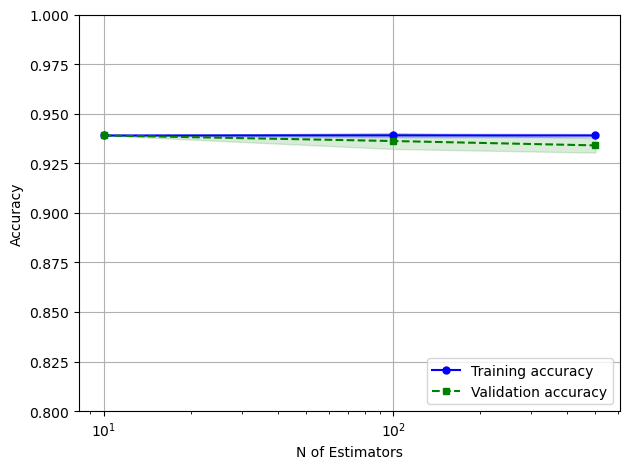

In [26]:
pipe_ada = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        AdaBoostClassifier(estimator=tree_1, 
                         learning_rate=0.1,
                         random_state=1))

estim_range = [10, 100, 500]

train_scores, test_scores = validation_curve(
                estimator= pipe_ada, 
                X=X_train, 
                y=y_train, 
                param_name='adaboostclassifier__n_estimators', 
                param_range=estim_range,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(estim_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(estim_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(estim_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(estim_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('N of Estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [27]:
print("Validation set means")
print("C=", estim_range[0], "   Accuracy:", test_mean[0])
print("C=", estim_range[1], "  Accuracy:", test_mean[1])
print("C=", estim_range[2], "  Accuracy:", test_mean[2])

Validation set means
C= 10    Accuracy: 0.9389999999999998
C= 100   Accuracy: 0.9362
C= 500   Accuracy: 0.9339999999999999


The Ada Boost Model, with 
- n_estimators: 10
- max_depth: 1

has an Accuracy Score on the Test dataset of 0.985

In [28]:
clf_ada = gs_ada.best_estimator_
clf_ada_score = clf_ada.score(X_test, y_test_int)

print("Best hyperparameters:", gs_ada.best_params_)
print('Test accuracy: %.3f' % clf_ada_score)

Selected_Hyperparametes.append(clf_ada_score)

Best hyperparameters: {'adaboostclassifier__estimator': DecisionTreeClassifier(max_depth=1, random_state=1), 'adaboostclassifier__n_estimators': 10}
Test accuracy: 0.985


# Results

Results are shown as Accuracy calculated on the Test Dataset.
The selection of hyperparameters reveladed to be particularly effective in improving the Ada Boost, and allowed some slight improvements in the LR model.

In [29]:
index = np.array(["SVC", "LR", "ADA BOOST"])

results = pd.DataFrame(zip(index, Default_Hyperparametes, Selected_Hyperparametes), columns=['Models','Default Hyperparametes','Selected Hyperparametes'])
results

,Models,Default Hyperparametes,Selected Hyperparametes
0,SVC,0.9852,0.9852
1,LR,0.9832,0.9852
2,ADA BOOST,0.9364,0.9852
